# Import package modules

In [1]:
from vesicle_picker import (
    preprocess,
    generate_masks,
    postprocess,
    helpers,
    external_import,
    external_export,
    funcs_mrcio
)
import matplotlib.pyplot as plt
import numpy as np
import cv2
import pandas as pd

# Import a micrograph from CryoSPARC

In [6]:
# Use the csparc_import module to initialize a cryosparc session
cs = external_import.load_cryosparc("../csparc_login.ini")

Connection succeeded to CryoSPARC command_core at http://burton.sickkids.ca:61002
Connection succeeded to CryoSPARC command_vis at http://burton.sickkids.ca:61003
Connection succeeded to CryoSPARC command_rtp at http://burton.sickkids.ca:61005


/home/rk/vesicle-picker/vesicle_picker/external_import.py:29: UserWarning: CryoSPARC instance burton.sickkids.ca:61000 with version v4.6.0-privatebeta.3 may not be compatible with current cryosparc-tools version v4.5.0.

To install a compatible version of cryosparc-tools:

    pip install --force cryosparc-tools~=4.6.0

Or, if running a CryoSPARC pre-release or private beta:

    pip install --no-cache --force https://github.com/cryoem-uoft/cryosparc-tools/archive/refs/heads/develop.zip

  cs = CryoSPARC(


In [7]:
# Pull micrographs object from the output of a curate job
micrographs = external_import.micrographs_from_csparc(
    cs = cs,
    project_id = "PXX", 
    job_id = "JXX", 
    job_type = "curate"
)

project = cs.find_project("PXX")

In [91]:
# Isolate and download just the first micrograph
micrograph = micrographs[1]
header, image_fullres = (
    project.download_mrc(micrograph["micrograph_blob/path"])
)

# Isolate the 2D numpy array containing the image
image_fullres = image_fullres[0]

# Import a micrograph from disk

In [ ]:
# Define an import function
def import_mrc(filename):
    """Use funcs_mrcio to open a specified .mrc file"""
    # Read the .mrc file in binary
    micrograph = open(filename, 'rb')

    # Use funcs_mrcio to extract image array and
    # rescale values to lie between [-1, 1]
    image = funcs_mrcio.irdsec_opened(micrograph, 0)

    # Use funcs_mrcio to extract header info
    header = funcs_mrcio.irdhdr_opened(micrograph)

    # Return the rescaled image and header
    return image, header

In [ ]:
# Import the example mrc
image_fullres, header = import_mrc("vesicles.mrc")

# Preprocess micrograph

In [92]:
# Use the preprocess module to get micrograph ready for segmentation
preprocessed_micrograph = preprocess.preprocess_micrograph(
    image_fullres,
    downsample=4,
    lowpass_mode="bilateral",
    d=17,
    sigmaColor=71,
    sigmaSpace=71
)

(-0.5, 1439.5, 1022.5, -0.5)

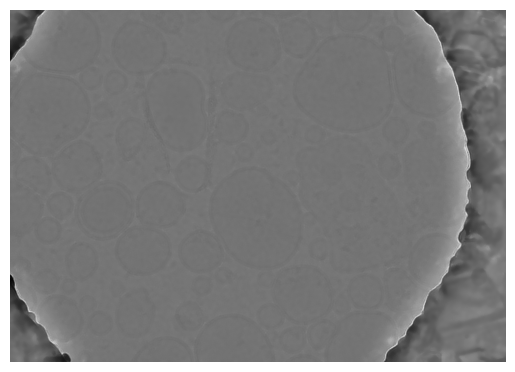

In [93]:
# Display the preprocessed micrograph
plt.imshow(preprocessed_micrograph, cmap="Greys_r")
plt.axis('off')

# Generate masks

In [14]:
# Use the generate_masks module to perform automatic image segmentation
# Initialize the model
model = generate_masks.initialize_model(
    model_weights_path="../sam_vit_h_4b8939.pth",
    device='cuda:0'
)

In [94]:
# Generate masks with user-optimized parameters
masks = generate_masks.generate_masks(
    preprocessed_micrograph,
    model,
    points_per_side=36,
    points_per_batch=16,
    pred_iou_thresh=0.9,
    stability_score_thresh=0.9,
    crop_n_layers=1,
    crop_n_points_downscale_factor=2,
    crop_nms_thresh=0.1,
    min_mask_region_area=100,
    psize=1.07,
    downsample=4
)

# Postprocess masks

In [95]:
# Use the postprocess module to compute statistics on the vesicles
postprocessed_masks = postprocess.postprocess_masks(
    masks,
    [
        postprocess.find_mask_intensity,
        postprocess.find_contour,
        postprocess.find_roundness,
        postprocess.fit_ellipse
    ],
    preprocessed_micrograph
)

In [96]:
# Filter these vesicles based on min and max values recorded in 'filters.ini'
filtered_masks = postprocess.apply_filters(postprocessed_masks, "filters.ini")

# Use the extract_statistics function to generate Pandas Dataframes
# of the postprocessed values, for downstream analysis.
unfiltered_dataset, filtered_dataset = (
    postprocess.extract_statistics(postprocessed_masks, "filters.ini")
)

pd.DataFrame(filtered_dataset)

,area,roundness,intensity
0,61097,0.877519,-0.117720
1,19157,0.897415,-0.055150
2,5791,0.808987,-0.003547
3,3981,0.894789,-0.009824
4,8971,0.867761,-0.009742
...,...,...,...
64,3586,0.832842,0.004536
65,1309,0.830798,-0.000978
66,33832,0.754355,0.740216
67,6596,0.719043,-0.023067


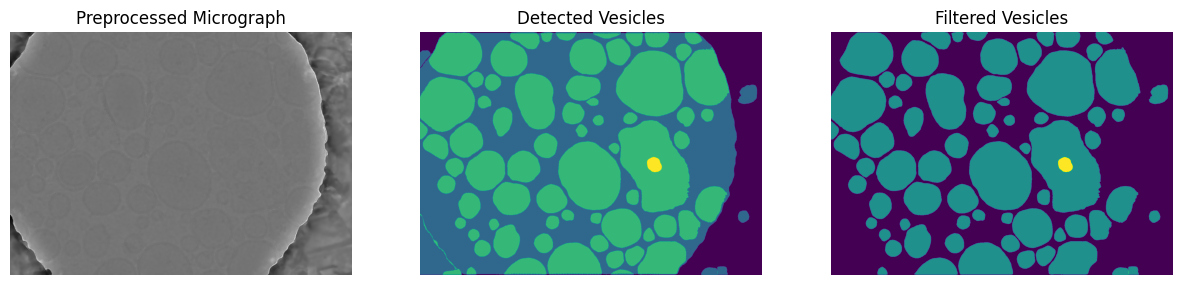

In [97]:
# Create a figure with three subplots arranged in a row
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot the first image in the first subplot
axes[0].imshow(preprocessed_micrograph, cmap="Greys_r")
axes[0].set_title('Preprocessed Micrograph')

# Plot the second image in the second subplot
axes[1].imshow(helpers.sum_masks(masks, 'segmentation'))
axes[1].set_title('Detected Vesicles')

# # Plot the third image in the third subplot
axes[2].imshow(helpers.sum_masks(filtered_masks, 'segmentation'))
axes[2].set_title('Filtered Vesicles')

# Remove axis labels and ticks
for ax in axes:
    ax.axis('off')

In [90]:
# Once you have a set of filters you like, generate the picks
pick_indices = postprocess.generate_picks(
    filtered_masks,
    psize=1.03,
    downsample=4,
    box_size=100,
    mode='edge'
)

AssertionError: 1440 cols is not evenly divisible by 31

In [ ]:
# Dilate the masks
dilated_masks = postprocess.dilate_masks(
    filtered_masks,
    dilation=100,
    psize=1.03,
    downsample=4
)

# Generate picks on dilated masks
dilated_pick_indices = postprocess.generate_picks(
    dilated_masks,
    psize=1.03,
    downsample=4,
    box_size=100,
    mode='edge'
)

In [ ]:
# Plot the preprocessed micrograph with picks overlaid
plot_micrograph = preprocess.preprocess_micrograph(
    image_fullres,
    downsample=4,
    lowpass_mode="bilateral",
    d=11,
    sigmaColor=71,
    sigmaSpace=71
)
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.imshow(plot_micrograph, cmap="Greys_r")

# Overlay the undilated picks
ax1.scatter(x=pick_indices[1]/4,
            y=pick_indices[0]/4,
            marker='x',
            color='red',
            s=1,
            label='original')

# And the dilated picks
ax1.scatter(x=dilated_pick_indices[1]/4,
            y=dilated_pick_indices[0]/4,
            marker='x',
            color='blue',
            s=1,
            label='dilated')

plt.legend()
plt.axis('off')
plt.show()

# Export pick locations to CryoSPARC

In [ ]:
# Adjust the pick values to reflect initial upsampling of image
pick_indices = postprocess.generate_picks(
    filtered_masks,
    psize=1.03,
    downsample=4,
    box_size=16,
    mode="edge"
)

In [ ]:
# Use the csparc_export module to construct
# a dataset for export back to cryosparc
pick_dataset = external_export.construct_csparc_dataset(
    micrograph,
    pick_indices
)

In [ ]:
# Send the dataset back to cryosparc
csparc_export.export_to_csparc(cs, pick_dataset, "PXX", "WXX")

In [ ]:
# Initialize project and job
project = cs.find_project("PXX")
job = project.create_external_job("WXX", title="Vesicle Picks")

# Tell the job what kind of output to expect
job.add_output("particle", "vesicle_picks", slots=["location"])

# Start the job, push the output to cryosparc, stop the job
job.start()
job.save_output("vesicle_picks", pick_dataset)
job.stop()